In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [33]:
import torch
import numpy as np
from pathlib import Path
import numpy as np
import cv2
from transforms3d.quaternions import quat2mat

VERTEX_COLORS = [
    (0, 0, 0),
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (1, 1, 1),
    (0, 1, 1),
    (1, 0, 1),
    (1, 1, 0),
]


def get_corners():
    """Get 8 corners of a cuboid. (The order follows OrientedBoundingBox in open3d)
        (y)
        2 -------- 7
       /|         /|
      5 -------- 4 .
      | |        | |
      . 0 -------- 1 (x)
      |/         |/
      3 -------- 6
      (z)
    """
    corners = np.array(
        [
            [0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0],
            [1.0, 1.0, 1.0],
            [0.0, 1.0, 1.0],
            [1.0, 0.0, 1.0],
            [1.0, 1.0, 0.0],
        ]
    )
    return corners - [0.5, 0.5, 0.5]


def get_edges(corners):
    assert len(corners) == 8
    edges = []
    for i in range(8):
        for j in range(i + 1, 8):
            if np.sum(corners[i] == corners[j]) == 2:
                edges.append((i, j))
    assert len(edges) == 12
    return edges


def draw_projected_box3d(
    image, center, size, rotation, extrinsic, intrinsic, color=(0, 1, 0), thickness=1
,verts=None):
    """Draw a projected 3D bounding box on the image.

    Args:
        image (np.ndarray): [H, W, 3] array.
        center: [3]
        size: [3]
        rotation (np.ndarray): [3, 3]
        extrinsic (np.ndarray): [4, 4]
        intrinsic (np.ndarray): [3, 3]
        color: [3]
        thickness (int): thickness of lines
    Returns:
        np.ndarray: updated image.
    """
    if verts is None:
        corners = get_corners()  # [8, 3]
    else: 
        corners = verts
    # edges = get_edges(corners)  # [12, 2]
    corners = corners * size
    corners_world = corners @ rotation.T + center
    corners_camera = corners_world @ extrinsic[:3, :3].T + extrinsic[:3, 3]
    corners_image = corners_camera @ intrinsic.T
    uv = corners_image[:, 0:2] / corners_image[:, 2:]
    uv = uv.astype(int)

    # for (i, j) in edges:
    #     cv2.line(
    #         image,
    #         (uv[i, 0], uv[i, 1]),
    #         (uv[j, 0], uv[j, 1]),
    #         tuple(color),
    #         thickness,
    #         cv2.LINE_AA,
    #     )

    for i, (u, v) in enumerate(uv):
        cv2.circle(image, (u, v), radius=1, color=VERTEX_COLORS[0], thickness=1)
    return image

In [3]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return prefix,rgb, depth, label, meta

In [4]:
split_dir = '../dataset/training_data/training_data_filtered/training_data/splits/v2/'
training_data_dir = '../dataset/training_data/training_data_filtered/training_data/v2.2/'

In [5]:
prefix_names,rgb_files, depth_files, label_files, meta_files = get_split_files('val')

In [6]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

## Get familiar with the data

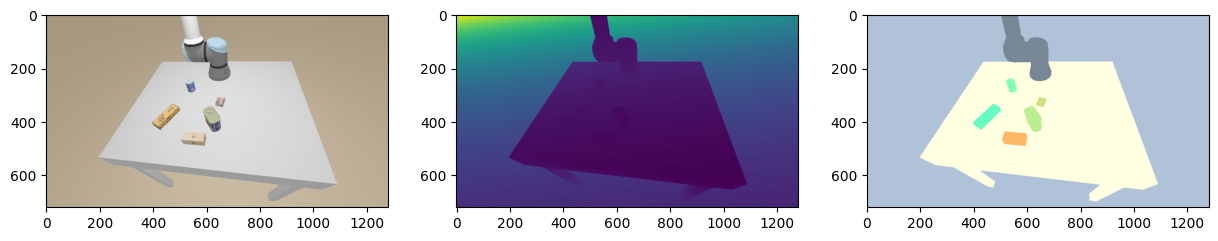

In [7]:
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [8]:
meta = load_pickle(meta_files[0])
meta.keys()

dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

In [9]:
meta['object_names'], meta['object_ids']

(['jenga', 'master_chef_can', 'potted_meat_can', 'pudding_box', 'wood_block'],
 array([35, 39, 48, 51, 58]))

In [10]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

## Lift depth to point cloud

In [135]:
z

array([[6.007, 6.003, 5.999, ..., 3.203, 3.202, 3.201],
       [5.975, 5.971, 5.967, ..., 3.194, 3.193, 3.192],
       [5.944, 5.94 , 5.936, ..., 3.185, 3.184, 3.183],
       ...,
       [1.251, 1.25 , 1.25 , ..., 1.058, 1.058, 1.057],
       [1.249, 1.249, 1.249, ..., 1.057, 1.057, 1.056],
       [1.248, 1.248, 1.247, ..., 1.056, 1.056, 1.056]])

In [11]:
intrinsic = meta['intrinsic']
z = depth
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
# points_viewer
print(u[0,0])
print((u + 0.5 - intrinsic[0,2])[0,0])
print(((u + 0.5 - intrinsic[0,2])/intrinsic[0,0])[0,0])
print((z*(u + 0.5 - intrinsic[0,2])/intrinsic[0,0])[0,0])
XU = z*(u + 0.5 - intrinsic[0,2])/intrinsic[0,0]
XU[0,0],points_viewer[0,0,0]


0
-639.5
-1.2438269974187899
-7.47166877349467


(-7.47166877349467, -7.471668773494669)

In [137]:
depth_im

tensor([[[0.0917, 0.0916, 0.0915,  ..., 0.0489, 0.0489, 0.0488],
         [0.0912, 0.0911, 0.0911,  ..., 0.0487, 0.0487, 0.0487],
         [0.0907, 0.0906, 0.0906,  ..., 0.0486, 0.0486, 0.0486],
         ...,
         [0.0191, 0.0191, 0.0191,  ..., 0.0161, 0.0161, 0.0161],
         [0.0191, 0.0191, 0.0191,  ..., 0.0161, 0.0161, 0.0161],
         [0.0190, 0.0190, 0.0190,  ..., 0.0161, 0.0161, 0.0161]]],
       device='cuda:0')

In [133]:
u = torch.arange(width) * torch.ones([bs,height, width])
u = u.to(device)
print(u[0,0,0])
print((u + 0.5- cx[:,None,None])[0,0,0])
print(((u + 0.5- cx[:,None,None])/fx[:,None,None])[0,0,0])
TU = (u + 0.5- cx[:,None,None]) * depth_im / fx[:,None,None]
TU[0,0,0]

tensor(0., device='cuda:0')
tensor(-639.5000, device='cuda:0', dtype=torch.float64)
tensor(-1.2438, device='cuda:0', dtype=torch.float64)


tensor(-0.1140, device='cuda:0', dtype=torch.float64)

# Debug renderer.py  

In [50]:
debug_name = os.path.basename(prefix_names[0])

In [12]:
from dataloader import SyntheticDataset
from pose_estimation import ObjectPoseEstimator
from utils import *

obe = ObjectPoseEstimator()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 470.223.02


In [13]:
dataset = SyntheticDataset(split_type='val')
device = torch.device('cuda' if CUDA else 'cpu')
sample = dataset[0]
depth_im = torch.from_numpy(sample['depth'])[None].to(device)
bs, height, width = depth_im.shape
intrin = torch.from_numpy(sample['intrinsic'])[None].to(device)
# fx, cx, fy, cy = intrin[:,0,0], intrin[:,0,2], intrin[:,1,1], intrin[:,1,2]
pcd = obe.depth2pc(depth_im,intrin)

In [11]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

In [25]:

poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
index = [ MESHID2CLASS[x] for x in  meta['object_ids'] ]
verts = [ x.cpu().data.numpy() for x in obe.meshloader.pmeshes.verts_list()]
faces = [ x.cpu().data.numpy() for x in obe.meshloader.pmeshes.faces_list()]


(array([0.14999996, 0.04999994, 0.02999996], dtype=float32),
 array([1., 1., 1.], dtype=float32))

In [42]:
, box_sizes[0]  ,meta['extents'][1] , meta['scales'][1], meta['extents'][meta['object_ids'][0]], meta['scales'][meta['object_ids'][0]]

(array([0.03205949, 0.01625746, 0.01196396], dtype=float32),
 array([-0.03205949, -0.01625746, -0.01196396], dtype=float32),
 array([0.14999996, 0.04999994, 0.02999996], dtype=float32),
 None,
 None)

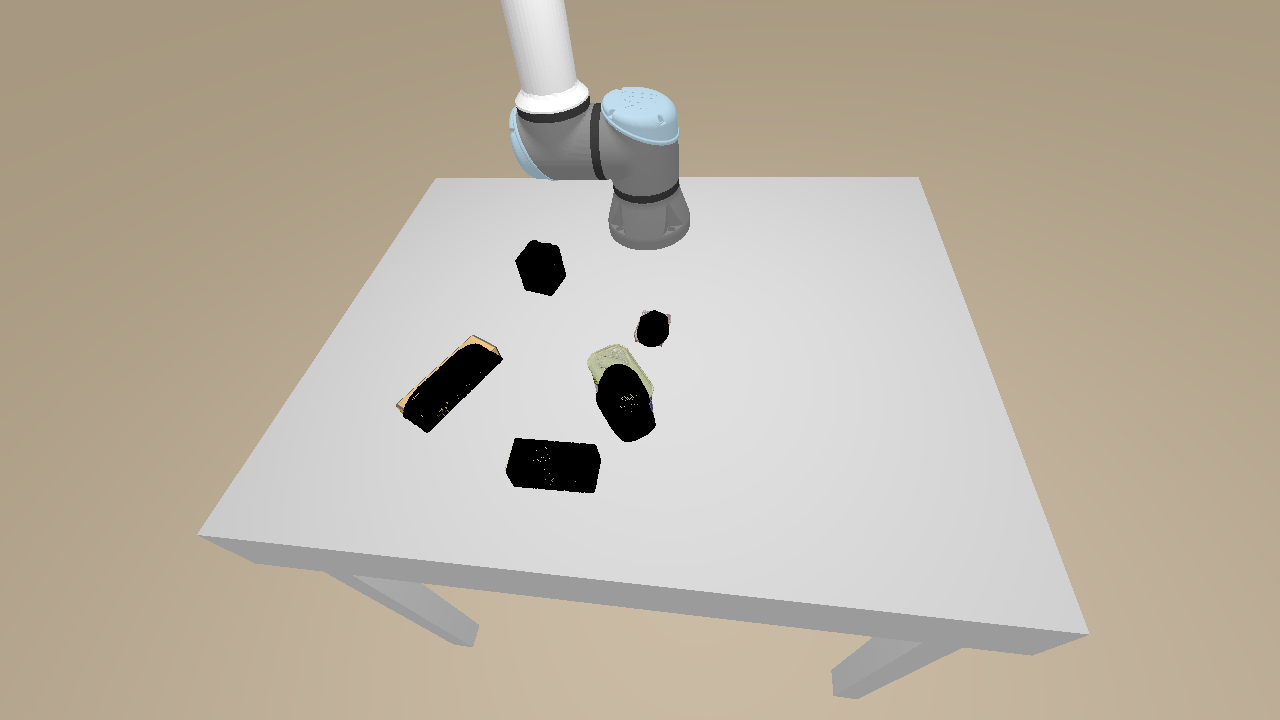

In [48]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    box_sizes_t = box_sizes[i]/(verts[i].max(axis=0)-verts[i].min(axis=0))
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes_t, poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2,verts=verts[i])

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [13]:
load_pickle("./testing_data/v2.2/1-1-1_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

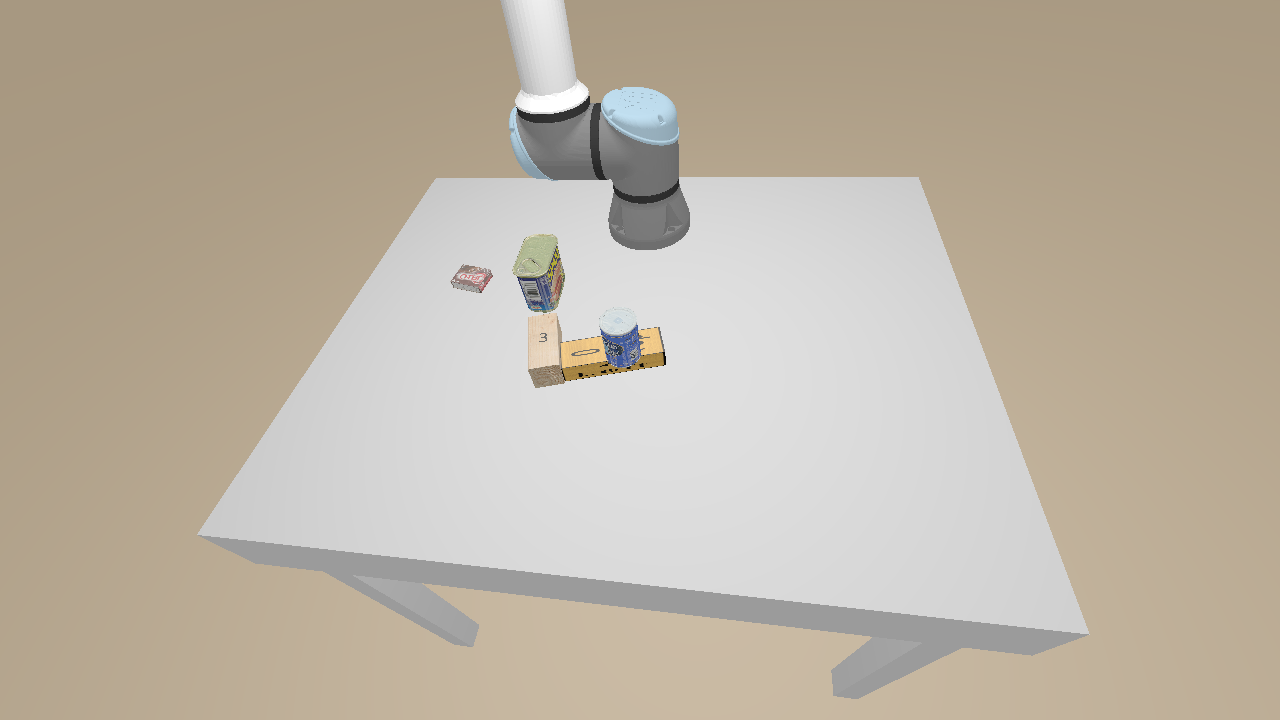

In [14]:
Image.open("./testing_data/v2.2/1-1-1_color_kinect.png")